In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import json
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append('..')
from utils import nethook
from utils import model_utils

## Load Model

In [3]:
MODEL_NAME = "gpt2-medium"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=False)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [4]:
prompt = [
    "Apple has recently released their iPhone 14 line of",
    "Goole has released Pixel 7",
    "I am taking a Machine Learning class",
    "Eiffel Tower is in Paris."
]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = False,
    max_out_len= 50,
    # debug=True,
    get_answer_tokens=True,
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

Apple has recently released their iPhone 14 line of
Apple has recently released their iPhone 14 line of phones, which are designed to run the latest iOS 9.0, but the company has yet to release a new iPhone model.  The latest version of Apple is called the iPhone 8, which is
p(answer):  p(' devices'[4410])=0.2049, p(' phones'[9512])=0.1882, p(' smartphones'[18151])=0.1707, p(' hands'[2832])=0.0887, p(' products'[3186])=0.0367

Goole has released Pixel 7
Goole has released Pixel 7.1, which is a new update to Android Marshmallow that includes a lot of new features. The biggest new feature is a new "Pixel Launcher". It is a customisable launcher that is available from the settings
p(answer):  p(' and'[290])=0.1817, p(','[11])=0.0804, p('.'[13])=0.0659, p(' Plus'[8227])=0.0247, p(' on'[319])=0.0194

I am taking a Machine Learning class
I am taking a Machine Learning class at Stanford University, and I have been doing it for years now. I am currently using Python as well as Caffe, but I have

## Dataset (the `IMDB_50K_Reviews` dataset)

In [5]:
df = pd.read_csv("../Data/IMDB_50K_Reviews/archive/IMDB Dataset.csv")
df = df.sample(frac = 1)
df.head()

,review,sentiment
38747,.... could it be that ITV wouldn't want to rel...,positive
32984,A typical Lanza flick that had limited audienc...,negative
10374,Kurt Thomas stars as Jonathan Cabot some kind ...,negative
32170,"It's a gentle, easy-going 1950s comedy. Kim No...",positive
21268,"As you may have gathered from the title, I who...",negative


In [6]:
for index, row in df.iterrows():
    print(row["review"])
    print(row["sentiment"])
    break

.... could it be that ITV wouldn't want to release this absolute classic because it would show up their current series of Mike Bassett for what it is? When discussing Mike Bassett with some work colleagues I mentioned Bostock's Cup as being a far superior offering and was surprised to find that I seem to be the only person in my entire office that has actually seen it. This can't be right for a film that has got to be the funniest thing I have ever seen.<br /><br />Let's face it, ITV don't have the greatest recent record for producing comedy so you would think that they would jump at the chance of at least repeating something which is genuinely funny. Perhaps if it could be combined with a lucrative telephone competition of where we think the coach driver will go next then they might be interested.<br /><br />Come on ITV, there are still some of us out there who would like to watch original, quality comedy/drama. Do the decent thing thing. Repeat it then get it out on DVD.
positive


In [7]:
train_df = df[0:30000]
validation_df = df[30000:40000]
test_df = df[40000:50000]

In [8]:
train_df.shape, validation_df.shape, test_df.shape

((30000, 2), (10000, 2), (10000, 2))

## Load presaved Data

In [5]:
train_df = pd.read_csv("../Data/IMDB_50K_Reviews/train.csv")
validation_df = pd.read_csv("../Data/IMDB_50K_Reviews/validation.csv")
test_df = pd.read_csv("../Data/IMDB_50K_Reviews/test.csv")

## Dataloader

In [6]:
from torch.utils.data import DataLoader, Dataset

import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|/.*/')

def cleanhtml(raw_html):
  raw_html = raw_html.replace("\\", "")
  raw_html = raw_html.replace("&#039;", "\'")
  cleantext = re.sub(CLEANR, ' ', raw_html)
  split = cleantext.strip().split(" ")
  if(split[0].isnumeric()):
    split = split[1:]
  return " ".join([w for w in split if len(w.strip()) > 0])

# cleanhtml("Don&#039;t mess with me")
# cleanhtml('<a href="#p79290593" class="quotelink">&gt;&gt;79290593</a><br><span class="quote">&gt;canada</span><br><br>and you faggots think we&#039;re the worst shit posters')

class GoEmotions(Dataset):
    def __init__(self, data_frame):
        self.x = []
        self.y = []

        for index, row in data_frame.iterrows():
            self.x.append("<REVIEW>: " + cleanhtml(row["review"]) + " <SENTIMENT>")
            self.y.append(" " + row["sentiment"])
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [7]:
training_dataset = GoEmotions(train_df)
validation_dataset = GoEmotions(validation_df)
test_dataset = GoEmotions(test_df)

len(training_dataset), len(validation_dataset), len(test_dataset)

(30000, 10000, 10000)

In [8]:
batch_size = 2

training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size)

## Tuning

In [9]:
embedder = "transformer.wte"
layer_norm_final = "transformer.ln_f"
transformer_blocks = [f"transformer.h.{n}" for n in range(model.config.n_layer)]
unembedder = "lm_head"

In [10]:
###############################################################################################################
prefix_size = 10
num_epochs = 10
###############################################################################################################

learning_rate = 5e-4
warmup_steps = 200
weight_decay = 0

optimization_batch_size = 8
max_token_per_comment = 963

save_path = f"../Saved_weights/Prefix-Tuned_CLF__IMDB_50K/{MODEL_NAME}"

In [11]:
embedder_module = nethook.get_module(model, embedder)
lm_head = nethook.get_module(model, unembedder)

In [12]:
import random

init_words = ["sentiment", "elephant", "review"]
def get_initial_prefix(prefix_size = 5):
    words = random.choices(init_words, k=prefix_size)
    sentence = " " + " ".join(words)
    tokenized = tokenizer(sentence, return_tensors = "pt").to(next(model.parameters()).device)
    return embedder_module(tokenized['input_ids'])

get_initial_prefix(7).shape

torch.Size([1, 7, 1024])

In [13]:
def untuple(output):
    if(type(output) is tuple):
        return output[0]
    return output

def get_shape(output):
    pre = f"{type(output)} ==> "
    if(type(output) is tuple):
        return pre + f"{output[0].shape} -- {(output[1][0].shape, output[1][1].shape)}"
    return pre + f"{output.shape}"

In [14]:
def get_prefix_tuning_edit(prefix_embeddings):
    def insert_prompt_embeddings(output, layer, prefix_embeddings = prefix_embeddings):
        if(layer not in prefix_embeddings):
            return output
        # print("intervention ==> ", layer, "output shape ===> ", get_shape(output))
        # return output
        X = untuple(output)
        prefix_now = prefix_embeddings[layer]
        prefix_size = prefix_now.shape[1]
        arr = []
        for batch in X:
            added = torch.cat((prefix_now[0], batch[prefix_size:, :]))
            arr.append(added)
        X = torch.stack(arr)

        if(type(output) is not tuple):
            return X
        else:
            return (X, output[1])
    return insert_prompt_embeddings

In [15]:
import copy

prefix_embeddings = {
    key: get_initial_prefix(prefix_size) for key in [embedder] + transformer_blocks[:-1]
}

init_states = copy.deepcopy(prefix_embeddings)

prefix_embeddings[embedder].shape


torch.Size([1, 10, 1024])

In [16]:
# prompt = [
#     "Apple has recently released their iPhone 14 line of",
#     "Goole has released Pixel 7",
#     "I am taking a Machine Learning class",
#     "Eiffel Tower is in Paris."
# ]

# txt, ret_dict = model_utils.generate_fast(
#     model, tokenizer,
#     prompt,
#     argmax_greedy = False,
#     max_out_len= 50,
#     get_answer_tokens=True,

#     light_weight_tuning= prefix_embeddings, algo = "prefix"
# )

# model_utils.print_formatted_results(prompt, txt, ret_dict)

Epoch 1


100%|██████████| 15000/15000 [23:05<00:00, 10.83it/s]


#####################  CHECKPOINT -- saving weights #####################


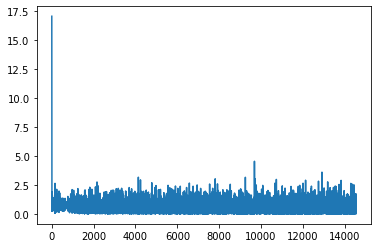

Epoch 2


100%|██████████| 15000/15000 [23:02<00:00, 10.85it/s]


#####################  CHECKPOINT -- saving weights #####################


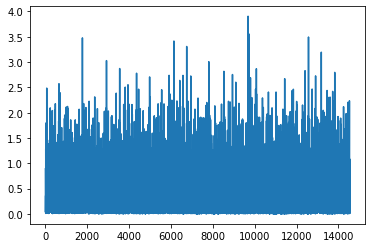

Epoch 3


100%|██████████| 15000/15000 [23:22<00:00, 10.70it/s]

#####################  CHECKPOINT -- saving weights #####################


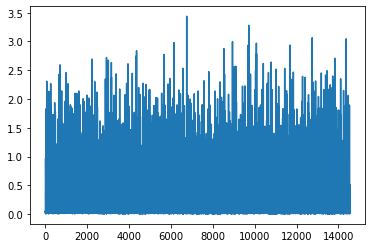

Epoch 4


100%|██████████| 15000/15000 [23:51<00:00, 10.48it/s]

#####################  CHECKPOINT -- saving weights #####################


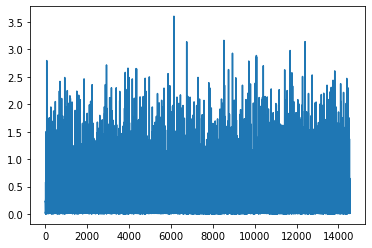

Epoch 5


100%|██████████| 15000/15000 [24:01<00:00, 10.41it/s]

#####################  CHECKPOINT -- saving weights #####################


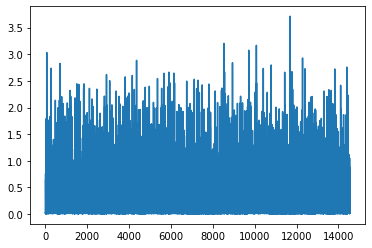

Epoch 6


100%|██████████| 15000/15000 [24:04<00:00, 10.39it/s]

#####################  CHECKPOINT -- saving weights #####################


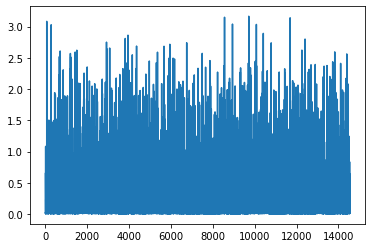

Epoch 7


100%|██████████| 15000/15000 [22:06<00:00, 11.31it/s]


#####################  CHECKPOINT -- saving weights #####################


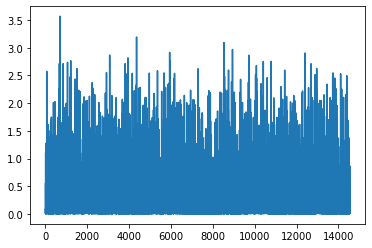

Epoch 8


100%|██████████| 15000/15000 [22:12<00:00, 11.26it/s]

#####################  CHECKPOINT -- saving weights #####################


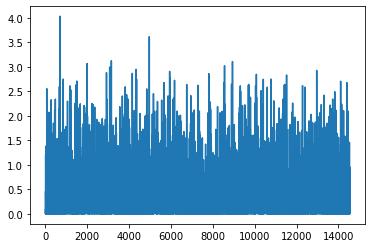

Epoch 9


100%|██████████| 15000/15000 [24:02<00:00, 10.40it/s]

#####################  CHECKPOINT -- saving weights #####################


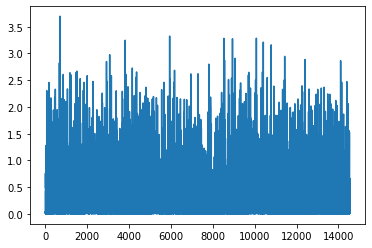

Epoch 10


100%|██████████| 15000/15000 [23:58<00:00, 10.43it/s]


#####################  CHECKPOINT -- saving weights #####################


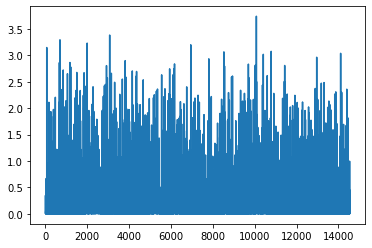

In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

# optimizer = AdamW(
#     # model.parameters(),
#     [v for _, v in tunable_weights.items()],
#     lr = learning_rate,
# )
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, num_warmup_steps=warmup_steps, num_training_steps=-1
# )

for k in prefix_embeddings:
    prefix_embeddings[k].requires_grad = True

for name, w in model.named_parameters():
    w.requires_grad = False

optimizer = torch.optim.Adam(
    [prefix_embeddings[k] for k in prefix_embeddings],
    lr=learning_rate,
    weight_decay=weight_decay,
)

num_prompts_optimized = 0
training_loss_track = []
validation_loss_track = []

target_track = {
    " positive": 0,
    " negative": 0
}

###############################################################################
insert_prefix_embeddings = get_prefix_tuning_edit(prefix_embeddings)
###############################################################################

limit = 700

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    for reviews, sentiments in tqdm(training_dataloader):
        tokenized_inputs = tokenizer(
            list(reviews),
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)

        # add soft tokens
        prefix_tokens = torch.ones(len(reviews), prefix_size, dtype = int).to(next(model.parameters()).device) * model.config.bos_token_id
        tokenized_inputs["input_ids"] = torch.cat((prefix_tokens, tokenized_inputs["input_ids"]), dim = 1)
        prefix_attn = torch.ones(len(reviews), prefix_size, dtype = int).to(next(model.parameters()).device)
        tokenized_inputs["attention_mask"] = torch.cat((prefix_attn, tokenized_inputs["attention_mask"]), dim = 1)

        if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
            # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
            continue
            
        for t in sentiments:
            target_track[t] += 1

        target_ids = tokenizer(
            list(sentiments), 
            padding = True,
            return_tensors="pt"
        ).to(next(model.parameters()).device)['input_ids']

        # print(sentiments)

        # print(tokenized_inputs['input_ids'].shape)
        # print(sentiments, target_ids)

        last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1) - 1
        loss_mask = target_ids != tokenizer.unk_token_id

        # tokenized["input_ids"].require_grad = True
        with nethook.TraceDict(
            model,
            [embedder, layer_norm_final] + transformer_blocks + [unembedder],
            edit_output=insert_prefix_embeddings
        ) as traces:
            outputs = model(
                **tokenized_inputs, 
                labels=tokenized_inputs['input_ids']
            )

        probs = torch.nn.functional.log_softmax(
            outputs.logits[torch.arange(batch_size), last_token_inds], dim=-1
        )
        # print(probs)

        loss = -(torch.gather(probs, 1, target_ids) * loss_mask).sum(1) / loss_mask.sum(1)
        loss = loss.mean()

        training_loss_track.append(loss.item())
        # print(loss)

        model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # limit -= 1
        # if(limit == 0):
        #     break
        
    print("#####################  CHECKPOINT -- saving weights #####################")
    os.makedirs(save_path, exist_ok = True)
    torch.save(prefix_embeddings, f"{save_path}/prefixtuned__epoch_{epoch+1}.pth")
    with open(f"{save_path}/loss_track_{epoch + 1}.json", "w") as f:
        json.dump({"training": training_loss_track, "validation": validation_loss_track}, f)
    
    plt.title("")
    plt.plot(training_loss_track)
    plt.show()
    training_loss_track = []
    # break

## Testing

In [18]:
# checkpoint = torch.load('../Saved_weights/Fine-Tuned_CLF__IMDB_50K/gpt2-medium/finetuned_0.pth')
# model.load_state_dict(checkpoint)

In [19]:
prompt = [
    "This was an awesome movie",
    "This was a bad movie",
    "This was not a good movie",
    "That movie was garbage"
]

prompt = ["<REVIEW>: " + p + " <SENTIMENT>" for p in prompt]

txt, ret_dict = model_utils.generate_fast(
    model, tokenizer,
    prompt,
    argmax_greedy = True,
    max_out_len= 40,
    # debug=True,
    get_answer_tokens=True,

    light_weight_tuning= prefix_embeddings, algo = "prefix"
    # track_interesting_words = [
    #     [" positive", " negative"],
    #     [" positive", " negative"]
    # ]
)

model_utils.print_formatted_results(prompt, txt, ret_dict)

<REVIEW>: This was an awesome movie <SENTIMENT>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><REVIEW>: This was an awesome movie <SENTIMENT> positive positive positive positive positive positive positive positive positive positive positive positive positive positive positive
p(answer):  p(' positive'[3967])=0.9945, p(' negative'[4633])=0.0054, p('positive'[24561])=0.0, p(' positively'[19888])=0.0, p(' Positive'[33733])=0.0

<REVIEW>: This was a bad movie <SENTIMENT>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><REVIEW>: This was a bad movie <SENTIMENT> negative negative negative negative negative negative negative negative negative negative negative negative negative negative negative
p(answer):  p(' negative'[4633])=0.9958, p(' positive'[3967])=0.004, p(' bad'[2089])=0.0, p('negative'[31591])=0.0, p(' Negative'[36183]

In [20]:
testing_dataloader = DataLoader(test_dataset, batch_size=1)

target = []
predict = []

for reviews, sentiment in tqdm(testing_dataloader):
    tokenized_inputs = tokenizer(
        list(reviews),
        padding = True,
        return_tensors="pt"
    ).to(next(model.parameters()).device)

    if(tokenized_inputs['input_ids'].shape[1] > max_token_per_comment):
        # print(f"BLOCKED ==> {tokenized_inputs['input_ids'].shape[1]}")
        continue

    last_token_inds = tokenized_inputs["attention_mask"].sum(dim=1)
    max_out_len = max(last_token_inds).item()

    with torch.no_grad():
        txt, ret_dict = model_utils.generate_fast(
            model, tokenizer,
            list(reviews),
            argmax_greedy = True,
            max_out_len= max_out_len + prefix_size + 3,
            # debug=True,
            get_answer_tokens=True,

            light_weight_tuning= prefix_embeddings, algo = "prefix"
        )

    for t, p in zip(list(sentiment), ret_dict['answer']):
        target.append(t)
        predict.append(p['top_token'])

    # print(txt, ret_dict['answer'])

    # break

100%|██████████| 10000/10000 [08:36<00:00, 19.35it/s]


In [21]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(target, predict).ravel()

print(tp, fp)
print(fn, tn)

4605 408
390 4435


In [23]:
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
balanced_acc = (sensitivity + specificity)/2

balanced_acc

0.9188383097117352

In [24]:
target_track

{' positive': 144460, ' negative': 146480}

: 